# Cyberbullying Detection
### Author: Diane Tunnicliffe

## Overview

As the social media world becomes more and more significant in all of our lives, many questions remain about the impacts of social media use on children. A major, current concern of many pediatric organizations and children's advocacy groups is the prevalence of cyberbullying on social media, and the negative effects that are observed as a result. Studies have shown that "Adolescents who are targeted via cyberbullying report increased depressive affect, anxiety, loneliness, suicidal behavior, and somatic symptoms. Perpetrators of cyberbullying are more likely to report increased substance use, aggression, and delinquent behaviors." [[1]](https://www.dovepress.com/current-perspectives-the-impact-of-cyberbullying-on-adolescent-health-peer-reviewed-fulltext-article-AHMT) That being said, it is of utmost importance to be able to predict cyberbullying as it happens, so that we can identify and remove these types of posts before they detrimentally affect our children.  

In this project, I will explain how cyberbullying can be classified and predicted, and provide exploratory data analysis to illustrate the wide range of topics that are included in this scope. I will then show how cyberbullying posts can be predicted by both classification models and recurrent neural networks (RNNs), and introduce an interface that can make predictions in realtime, so that posts like these can be detected before being seen by the public eye. 

## Business Problem
As a parent myself, with both an interest and academic background in psychology, I find myself feeling a strong need to protect children from online threats. But beyond my personal feelings about this problem, it has been shown to be a widespread issue that demands swift addressing.  

"Adolescents in the United States culture are moving from using the Internet as an “extra” in everyday communication (cyber utilization) to using it as a “primary and necessary” mode of communication (cyber immersion) In fact, 95% of adolescents are connected to the Internet. This shift from face-to-face communication to online communication has created a unique and potentially harmful dynamic for social relationships – a dynamic that has recently been explored in the literature as cyberbullying and Internet harassment." [[1]](https://www.dovepress.com/current-perspectives-the-impact-of-cyberbullying-on-adolescent-health-peer-reviewed-fulltext-article-AHMT) 

"Cyberbullying, while following many of the underlying dynamics of more traditional forms of bullying, features some unique qualities that can both magnify the damage caused and make it more difficult to detect. These features include the pervasive, never-ending nature of cyberbullying and the ability to quickly reach large audiences. The potential for anonymity and the related distance afforded by screens and devices compared to in-person interaction allow the cruelty of cyberbullying to go unchecked. Despite the perceived anonymity of cyberbullying, cyberbullying can be perpetrated by friends, who often have intimate knowledge about the victimised youth that can be devastating when made public." [[2]](https://journals.sagepub.com/doi/10.1177/0706743716684791)  



Since this is such a prevalent problem that we are dealing with as a society, we need to address the following questions:
1. What are the observable trends in the realm of toxicity, hate speech, and cyberbullying?
2. Can cyberbullying posts be classified and predicted ahead of time, before their detrimental impact occurs?
3. If so, then which type of algorithm can best address this issue?   

If we can answer these questions, then we can begin to protect both children and adults from the threat of cyberbullying and the very real impacts that it causes.

## Data Understanding


In [549]:
# importing the packages we will be using for this project
import pandas as pd
# setting pandas display to avoid scientific notation in my dataframes
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, Binarizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import PorterStemmer
import xgboost
import eli5
import tweepy
import unidecode
import google
import re
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
from itertools import islice


%matplotlib inline

### First Dataset: Kaggle Dataset for Detection of Cybertrolls

Dataset from https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls/

"The dataset has 20001 items of which 20001 items have been manually labeled. The labels are divided into following 2 categories:

1 (Cyber-Aggressive) 0 (Non Cyber-Aggressive)  

Tweets classified as aggressive or not to help fight trolls."



In [550]:
df = pd.read_json('data/Dataset for Detection of Cyber-Trolls.json', lines=True)
df.head()

,content,annotation,extras
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",nan
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",nan
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",nan
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",nan
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",nan


In [551]:
df["label"] = df.annotation.apply(lambda x: x.get('label'))
df["label"] = df.label.apply(lambda x: x[0])

df.head()

,content,annotation,extras,label
0,Get fucking real dude.,"{'notes': '', 'label': ['1']}",nan,1
1,She is as dirty as they come and that crook ...,"{'notes': '', 'label': ['1']}",nan,1
2,why did you fuck it up. I could do it all day...,"{'notes': '', 'label': ['1']}",nan,1
3,Dude they dont finish enclosing the fucking s...,"{'notes': '', 'label': ['1']}",nan,1
4,WTF are you talking about Men? No men thats n...,"{'notes': '', 'label': ['1']}",nan,1


In [552]:
df['extras'].value_counts()

Series([], Name: extras, dtype: int64)

In [553]:
df = df.drop(columns=['annotation', 'extras'])

In [554]:
df.head()

,content,label
0,Get fucking real dude.,1
1,She is as dirty as they come and that crook ...,1
2,why did you fuck it up. I could do it all day...,1
3,Dude they dont finish enclosing the fucking s...,1
4,WTF are you talking about Men? No men thats n...,1


In [555]:
df.shape

(20001, 2)

In [556]:
def countplot(data, xstring, title):
    '''Function to take in a dataframe, column name, and title. Returns Seaborn countplot.'''
    plt.figure(figsize=(6,4))
    g = sns.countplot(x=xstring, data=data, palette='viridis')
    plt.title(f'{title} Distribution', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
    g.set_xticks(range(len(data[xstring].value_counts())))
    g.set_xticklabels([f'Non-{title}', f'{title}']);

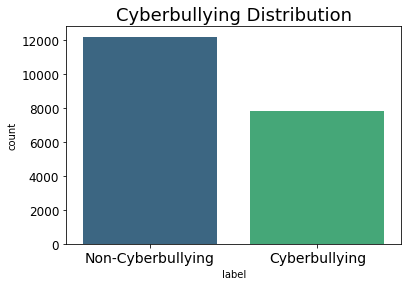

In [557]:
countplot(df, 'label', 'Cyberbullying')
#saved in images as fig1
#plt.tight_layout()
#plt.savefig('./images/fig1.png')

In [558]:
df.label.value_counts()

0    12179
1     7822
Name: label, dtype: int64

There is a bit of a class imbalance here, with 12,179 post classified as non-cyberbullying, and 7,822 posts classified as cyberbullying. 

### Second Dataset: Mendeley Data Cyberbullying Datasets

Dataset from https://data.mendeley.com/datasets/jf4pzyvnpj/1#__sid=js0


"This dataset is a collection of datasets from different sources related to the automatic detection of cyber-bullying. The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages and YouTube. The data contain text and labeled as bullying or not. The data contains different types of cyber-bullying like hate speech,  aggression,  insults and toxicity."

In [559]:
aggression = pd.read_csv('./data/aggression_parsed_dataset.csv')
aggression.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,0.900,0.100,0
1,1,` :: the term ``standard model`` is itself le...,1.000,0.000,0
2,2,"True or false, the situation as of March 200...",1.000,0.000,0
3,3,"Next, maybe you could work on being less cond...",0.556,0.444,0
4,4,This page will need disambiguation.,1.000,0.000,0


In [560]:
aggression.shape

(115864, 5)

In [561]:
aggression.oh_label.value_counts()

0    101082
1     14782
Name: oh_label, dtype: int64

In [562]:
aggression_1 = aggression.loc[aggression['oh_label']==1]

In [563]:
aggression_1.head()

,index,Text,ed_label_0,ed_label_1,oh_label
52,52,` :Click on my ``Annoying Users`` link! I gue...,0.474,0.526,1
60,60,Iraq is not good === === USA is bad,0.444,0.556,1
121,121,` Buddha - ``Some suggest that victims should...,0.200,0.800,1
207,207,____ fuck off you little asshole. If you wan...,0.000,1.000,1
351,351,"i have a dick, its bigger than yours! hahaha",0.100,0.900,1


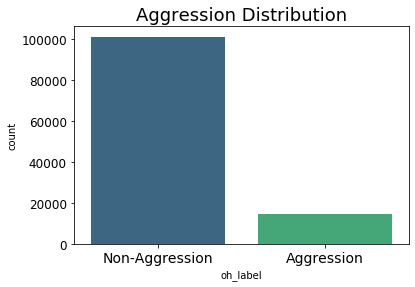

In [564]:
countplot(aggression, 'oh_label', 'Aggression')
#saved in images as fig2
#plt.tight_layout()
#plt.savefig('./images/fig2.png')

The Aggression dataset also shows significant class imbalance.

In [565]:
attack = pd.read_csv('./data/attack_parsed_dataset.csv')
attack.head()

,index,Text,ed_label_0,ed_label_1,oh_label
0,0,`- This is not ``creative``. Those are the di...,1.000,0.000,0
1,1,` :: the term ``standard model`` is itself le...,1.000,0.000,0
2,2,"True or false, the situation as of March 200...",1.000,0.000,0
3,3,"Next, maybe you could work on being less cond...",0.556,0.444,0
4,4,This page will need disambiguation.,1.000,0.000,0


In [566]:
attack.oh_label.value_counts()

0    102274
1     13590
Name: oh_label, dtype: int64

In [567]:
attack_1 = attack.loc[attack['oh_label']==1]
attack_1.head()

,index,Text,ed_label_0,ed_label_1,oh_label
60,60,Iraq is not good === === USA is bad,0.444,0.556,1
207,207,____ fuck off you little asshole. If you wan...,0.000,1.000,1
351,351,"i have a dick, its bigger than yours! hahaha",0.100,0.900,1
492,492,== renault == you sad little bpy for drivin...,0.100,0.900,1
493,493,== renault == you sad little bo for driving...,0.300,0.700,1


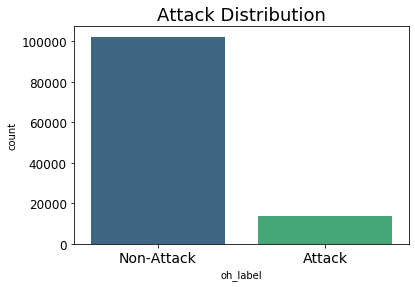

In [568]:
countplot(attack, 'oh_label', 'Attack')
#saved in images as fig3
#plt.tight_layout()
#plt.savefig('./images/fig3.png')

In [569]:
kaggle = pd.read_csv('./data/kaggle_parsed_dataset.csv', index_col=0)
kaggle.head()

,oh_label,Date,Text
index,,,
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [570]:
kaggle.shape

(8799, 3)

In [571]:
kaggle_1 = kaggle.loc[kaggle['oh_label']==1]
kaggle_1.head()

,oh_label,Date,Text
index,,,
0,1,20120618192155Z,"""You fuck your dad."""
7,1,NaN,"""shut the fuck up. you and the rest of your fa..."
8,1,20120502173553Z,"""Either you are fake or extremely stupid...may..."
9,1,20120620160512Z,"""That you are an idiot who understands neither..."
15,1,20120611090207Z,"""FOR SOME REASON U SOUND RETARDED. LOL. DAMN. ..."


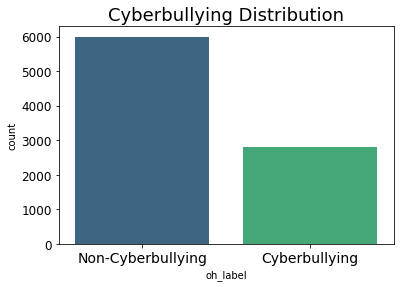

In [572]:
countplot(kaggle, 'oh_label', 'Cyberbullying')
#saved in images as fig4
#plt.tight_layout()
#plt.savefig('./images/fig4.png')

In [573]:
kaggle.oh_label.value_counts()

0    5993
1    2806
Name: oh_label, dtype: int64

Class imbalance here as well.

In [574]:
toxicity = pd.read_csv('./data/toxicity_parsed_dataset.csv', index_col=0)
toxicity.head()

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
0,This: :One can make an analogy in mathematical...,0.900,0.100,0
1,` :Clarification for you (and Zundark's righ...,1.000,0.000,0
2,Elected or Electoral? JHK,1.000,0.000,0
3,`This is such a fun entry. Devotchka I once...,1.000,0.000,0
4,Please relate the ozone hole to increases in c...,0.800,0.200,0


In [575]:
toxicity.shape

(159686, 4)

In [576]:
toxicity_1 = toxicity.loc[toxicity['oh_label']==1]
toxicity_1.head()

,Text,ed_label_0,ed_label_1,oh_label
index,,,,
82,"` After the wasted bit on his sexuality, I ha...",0.400,0.600,1
211,"Erik, for crying out loud. You legally can...",0.400,0.600,1
245,"BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOBS, BOOB...",0.125,0.875,1
334,```Nazi filth`` is impolite `,0.200,0.800,1
483,"Prior to Quickpolls, he would have been perma...",0.400,0.600,1


Upon inspection of the positive class, "toxicity" seems like a valid label for these comments.

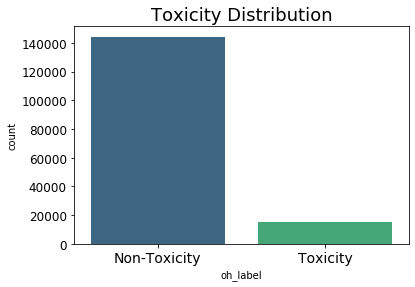

In [577]:
countplot(toxicity, 'oh_label', 'Toxicity')
#saved in images as fig5
#plt.tight_layout()
#plt.savefig('./images/fig5.png')

In [578]:
toxicity.oh_label.value_counts()

0    144324
1     15362
Name: oh_label, dtype: int64

Large class imbalance here as well.

In [579]:
twitter = pd.read_csv('./data/twitter_parsed_dataset.csv')
twitter.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.000
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.000
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.000
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.000
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.000


In [580]:
twitter.shape

(16851, 5)

In [581]:
twitter_1 = twitter.loc[twitter['oh_label']==1.00]
twitter_1.head()

,index,id,Text,Annotation,oh_label
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.000
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.000
6,4.36563082093949E+017,4.36563082093949E+017,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,sexism,1.000
9,5.00456367719989E+017,5.00456367719989E+017,RT @Newmanzaa: There's something wrong when a ...,sexism,1.000
11,5.61704465745465E+017,5.61704465745465E+017,@SirajZarook @OdiniaInvictus @BilalIGhumman @I...,racism,1.000


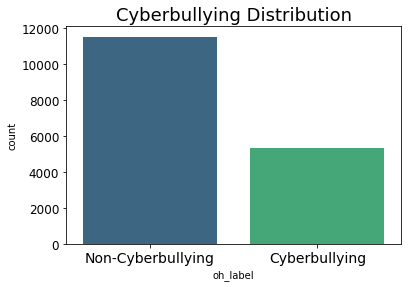

In [582]:
countplot(twitter, 'oh_label', 'Cyberbullying')
#saved in images as fig6
#plt.tight_layout()
#plt.savefig('./images/fig6.png')

In [583]:
twitter.oh_label.value_counts()

0.000    11501
1.000     5347
Name: oh_label, dtype: int64

More class imbalance.

In [584]:
racism = pd.read_csv('./data/twitter_racism_parsed_dataset.csv')
racism.head()

,index,id,Text,Annotation,oh_label
0,576749336190525056.000,576749336190525056.000,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,540890533389161024.000,540890533389161024.000,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,567843320338124992.000,567843320338124992.000,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,576646151631326976.000,576646151631326976.000,"Finally I'm all caught up, and that sudden dea...",none,0
4,571349195610681024.000,571349195610681024.000,@carolinesinders @herecomesfran *hugs*,none,0


In [585]:
racism.shape

(13471, 5)

In [586]:
racism_1 = racism.loc[racism['oh_label']==1]
racism.head()

,index,id,Text,Annotation,oh_label
0,576749336190525056.000,576749336190525056.000,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,540890533389161024.000,540890533389161024.000,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,567843320338124992.000,567843320338124992.000,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,576646151631326976.000,576646151631326976.000,"Finally I'm all caught up, and that sudden dea...",none,0
4,571349195610681024.000,571349195610681024.000,@carolinesinders @herecomesfran *hugs*,none,0


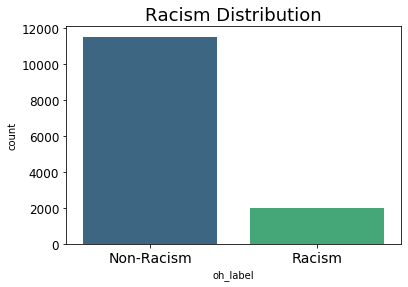

In [587]:
countplot(racism, 'oh_label', 'Racism')
#saved in images as fig7
#plt.tight_layout()
#plt.savefig('./images/fig7.png')

In [588]:
racism.oh_label.value_counts()

0    11501
1     1970
Name: oh_label, dtype: int64

Class imbalance is large here.

In [589]:
sexism = pd.read_csv('./data/twitter_sexism_parsed_dataset.csv')
sexism.head()

,index,id,Text,Annotation,oh_label
0,5.35198627292254E+017,5.35198627292254E+017,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.000
1,5.75984924030714E+017,5.75984924030714E+017,There's some very hate able teams this year #MKR,none,0.000
2,5.7233536016588E+017,5.7233536016588E+017,"RT @The_Eccles: ""Everyone underestimated us"" \...",none,0.000
3,5.72337925708374E+017,5.72337925708374E+017,RT @NOTLukeDarcy: did @Channel7 or #MKR actual...,none,0.000
4,4.43033024528011E+017,4.43033024528011E+017,"No, you don't. @Shut_Up_Jeff: I thought of a r...",sexism,1.000


In [590]:
sexism.shape

(14881, 5)

In [591]:
sexism_1 = sexism.loc[sexism['oh_label']==1]
sexism_1.head()

,index,id,Text,Annotation,oh_label
0,5.35198627292254E+017,5.35198627292254E+017,RT @BeepsS: @senna1 @BeepsS: I'm not sexist bu...,sexism,1.000
4,4.43033024528011E+017,4.43033024528011E+017,"No, you don't. @Shut_Up_Jeff: I thought of a r...",sexism,1.000
5,5.69577286308987E+017,5.69577286308987E+017,RT @Wateronatrain: @MT8_9 You might like this ...,sexism,1.000
10,5.68436168649343E+017,5.68436168649343E+017,"RT @MetalBarbieDoll: But yea, apparently #Game...",sexism,1.000
13,4.2696640533903E+017,4.2696640533903E+017,:D @nkrause11 Dudes who go to culinary school:...,sexism,1.000


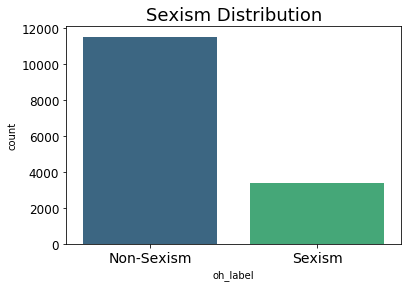

In [592]:
countplot(sexism, 'oh_label', 'Sexism')
#saved in images as fig8
#plt.tight_layout()
#plt.savefig('./images/fig8.png')

In [593]:
sexism.oh_label.value_counts()

0.000    11501
1.000     3377
Name: oh_label, dtype: int64

Another very imbalanced class.

In [594]:
youtube = pd.read_csv('./data/youtube_parsed_dataset.csv')
youtube.head()

,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
0,0,X1,Does N.e.bodyelse Hear her Crazy ass Screamin ...,10,1,3,3,0,15,0
1,1,X2,There are so many things that are incorrect wi...,3,0,6,5,0,31,0
2,2,X3,3:26 hahah my boyfriend showed this song to me...,7,0,3,5,0,43,1
3,3,X2218,dick beyonce fuck y a ass hole you are truely ...,34,0,3,5,0,44,1
4,4,X5,DongHaeTaemin and Kai ;A; luhansehun and bacon...,11,173,5,5,0,21,0


In [595]:
youtube.shape

(3464, 10)

In [596]:
youtube_1 = youtube.loc[youtube['oh_label']==1]
youtube_1.head()

,index,UserIndex,Text,Number of Comments,Number of Subscribers,Membership Duration,Number of Uploads,Profanity in UserID,Age,oh_label
2,2,X3,3:26 hahah my boyfriend showed this song to me...,7,0,3,5,0,43,1
3,3,X2218,dick beyonce fuck y a ass hole you are truely ...,34,0,3,5,0,44,1
21,21,X811,@RossJohn69 STFU with ur god bullshit u dumbas...,36,2,2,5,0,22,1
23,23,X24,Ugh Martin joins DaveChaos in my hatred for bi...,6,1,5,5,0,21,1
25,25,X26,If you ever hit or shoot a cop just say you di...,35,1,7,5,0,62,1


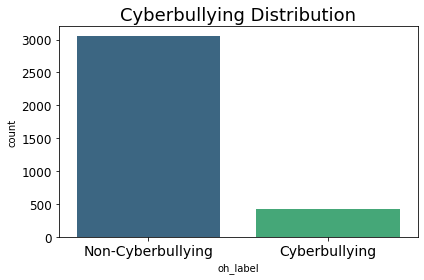

In [597]:
countplot(youtube, 'oh_label', 'Cyberbullying')
#saved in images as fig9
plt.tight_layout()
plt.savefig('./images/fig9.png')

In [598]:
youtube.oh_label.value_counts()

0    3047
1     417
Name: oh_label, dtype: int64

Another imbalanced class.

## Data Preparation

In order to prepare the data for the modeling process, I will be combining the datasets into a singular dataframe. I will be dropping all columns aside from the content column, containing the text to be classified as cyberbullying or not, and the label column. I will also need to rename some of these columns so that they can be combined more easily.

In [599]:
def clean(dataframe):
    '''
    Takes in a dataframe, removes columns with certain names, renames columns with certain names.
    Returns cleaned dataframe. 
    '''
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('index')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('id')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('ed_label_0')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('ed_label_1')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Date')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Annotation')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('UserIndex')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Number of Comments')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Number of Subscribers')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Membership Duration')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Number of Uploads')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Profanity in UserID')], 1, inplace=True)
    dataframe.drop(dataframe.columns[dataframe.columns.str.contains('Age')], 1, inplace=True)
    dataframe.rename(columns={'Text':'content', 'oh_label':'label'}, inplace=True)
    return dataframe

dataframes = [df, aggression, attack, kaggle, toxicity, twitter, racism, sexism, youtube]

for dataframe in dataframes:
    clean(dataframe)

In [600]:
dataframes = [df, aggression, attack, kaggle, toxicity, twitter, racism, sexism, youtube]

for dataframe in dataframes:
    print(dataframe.shape)

(20001, 2)
(115864, 2)
(115864, 2)
(8799, 2)
(159686, 2)
(16851, 2)
(13471, 2)
(14881, 2)
(3464, 2)


In [601]:
# combining dataframes into one
df = df.append([aggression, attack, kaggle, toxicity, twitter, racism, sexism, youtube], ignore_index=True)

In [602]:
# showing columns of new dataframe
df.columns

Index(['content', 'label'], dtype='object')

In [603]:
df.shape

(468881, 2)

In [604]:
# checking for null values
df.isnull().sum()

content    2
label      6
dtype: int64

In [605]:
# dropping null values
df.dropna(axis=0, how='any', inplace=True)
df.isnull().sum()

content    0
label      0
dtype: int64

In [606]:
# generating duplicate rows by content
duplicates = df.loc[df.duplicated(subset=['content'])]

In [607]:
duplicates.shape

(228890, 2)

In [608]:
duplicates.head(25)

,content,label
385,#NAME?,1
441,#NAME?,1
494,#NAME?,1
544,#NAME?,1
898,#NAME?,1
961,i hate you,1
1167,wat a fag....,1
1396,that sucks :(,1
1576,I hate you,1
1662,because i'm a dumb ass.,1


After exploring and analyzing the duplicates, it appears that there are many common comments that frequently arise on social media. Since I don't want the model to be overfitted to these instances and would like it to be able to generalize to cyberbullying comments as much as possible, I will be removing the duplicate values and only keeping the first instance of each duplicated value in 'content'.

In [609]:
hate = df.loc[df['content']=='i hate you']
hate.shape

(9, 2)

In [610]:
damn = df.loc[df['content']=='damn.']
damn.shape

(9, 2)

In [611]:
df.drop_duplicates(subset='content', inplace=True)
df.shape

(239985, 2)

In [612]:
# getting label value counts
df.label.value_counts()

0    200576
1     24769
0     11851
1      2789
Name: label, dtype: int64

In [613]:
# converting labels to floats
df.label = df.label.astype(float)

In [614]:
# confirming label values
df.label.value_counts()

0.000    212427
1.000     27558
Name: label, dtype: int64

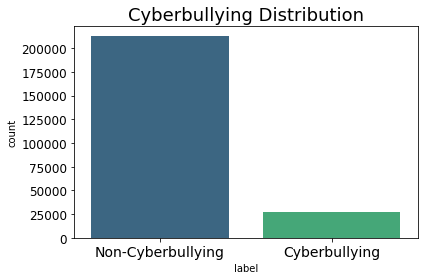

In [615]:
countplot(df, 'label', 'Cyberbullying')
#saved in images as fig10
#plt.tight_layout()
#plt.savefig('./images/fig10.png')

In [616]:
# confirming label values
df.label.value_counts()

0.000    212427
1.000     27558
Name: label, dtype: int64

The class imbalance in this dataset is very high, with 27,558 posts in the positive (cyberbullying) class and 212,427 posts in the negative (non-cyberbullying) class. I will be addressing this class imbalance within my model building pipeline.

In [617]:
#df.to_csv('data/combined_df.csv')

### Tokenizing & Removing Usernames
Two important steps in cleaning this dataset will be the tokenizing of the words and the removal of the usernames or "handles". Thanks to NLTK's TweetTokenizer, I can accomplish both in a single step. Below is an example of the simple TweetTokenizer.  

(I will be doing my full preprocessing of the data in the modeling pipeline notebook, but I will demonstrate these processes here for the purposes of EDA.)

In [618]:
# running an example of TweetTokenizer to illustrate how it works
print("Before tokenization: ", df.content[0])
tk = TweetTokenizer()
print("After tokenization: ", tk.tokenize(df.content[0]))

Before tokenization:   Get fucking real dude.
After tokenization:  ['Get', 'fucking', 'real', 'dude', '.']


By adding in the optional parameter "strip_handles=True", I can tokenize and remove the usernames all at once.

In [619]:
# running an example of TweetTokenizer with strip_handles
tk = TweetTokenizer(strip_handles=True)
print("Before tokenization & handle removal: ", df.content[423000])
print('\n After tokenization & handle removal: ',tk.tokenize(df.content[423000]))

Before tokenization & handle removal:  @Bahai144 @greta So get your fat ass off the couch and go and fight ISIS.  What is your problem? Are your legs broken or are you a coward?

 After tokenization & handle removal:  ['So', 'get', 'your', 'fat', 'ass', 'off', 'the', 'couch', 'and', 'go', 'and', 'fight', 'ISIS', '.', 'What', 'is', 'your', 'problem', '?', 'Are', 'your', 'legs', 'broken', 'or', 'are', 'you', 'a', 'coward', '?']


### Defining and Removing Stop Words
For this task, I will be using NLTK's English stop words list as the foundation for defining the stop words to be removed. I have also added punctuation to be removed as well as I do not believe it will be significant in the identification of cyberbullying posts.

In [620]:
# defining list of stop words
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [621]:
# function to accomplish the processing illustrated thus far
# by tokenizing, removing usernames, and removing stop words from content

def process(content):
    """ 
    Uses NLTK TweetTokenizer and stop words list to tokenize, remove usernames, and remove stop words from content. 
  
    Parameters: 
    content: Social media post (string).
  
    Returns: 
    Content after tokenization, username removal, and stop word removal.
  
    """
    tk = TweetTokenizer(strip_handles=True)
    tokens = tk.tokenize(content)
    processed_content = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return processed_content

In [622]:
# demonstrating function on prior example

print("Content before removing stop words: ", df.content[423000])
print("\n Tokens after removing usernames and stop words: ", process(df.content[423000]))

Content before removing stop words:  @Bahai144 @greta So get your fat ass off the couch and go and fight ISIS.  What is your problem? Are your legs broken or are you a coward?

 Tokens after removing usernames and stop words:  ['get', 'fat', 'ass', 'couch', 'go', 'fight', 'isis', 'problem', 'legs', 'broken', 'coward']


In [623]:
# copying dataframe for processing
processed = df.copy()

In [624]:
# processing content using process function
processed['content'] = list(map(process, processed['content']))

In [625]:
#checking out the result
print("Before: ", df.content[100])
print("\n After: ", processed.content[100])

Before:  I can see it now. "Listen  you cow-loving yahoos  just put all of the slurpee in this bag! What? Cups? I don't need fucking cups!

 After:  ['see', 'listen', 'cow-loving', 'yahoos', 'put', 'slurpee', 'bag', 'cups', 'need', 'fucking', 'cups']


In [626]:
#print (type(processed.loc[0, 'content']))

In [627]:
processed['content'] = processed['content'].str.join(', ')

In [628]:
#checking out the result
print("Before: ", df.content[100])
print("\n After: ", processed.content[100])

Before:  I can see it now. "Listen  you cow-loving yahoos  just put all of the slurpee in this bag! What? Cups? I don't need fucking cups!

 After:  see, listen, cow-loving, yahoos, put, slurpee, bag, cups, need, fucking, cups


In [366]:
#processed.to_csv('data/processed_df.csv')

While the data is not fully preprocessed yet, as it has not undergone stemming or vectorization, I will be pausing here for some visualizations.

## Visualizations

In [629]:
# separating positive and negative class content into two dataframes
# to be used for visualization purposes
non_cb = processed.copy()
non_cb = non_cb.loc[non_cb['label']==0]
non_cb['content'] = non_cb['content']

cb = processed.copy()
cb = cb.loc[cb['label']==1]
cb['content'] = cb['content']

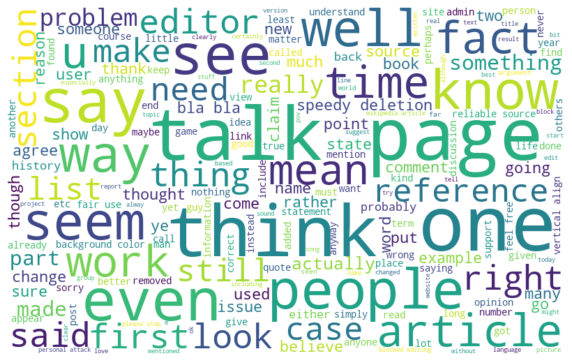

In [630]:
# generating a word cloud to see most frequent words in non-cyberbullying content
words = ' '.join([content for content in non_cb['content']])
wordcloud = WordCloud(width=800, height=500, random_state=18, max_font_size=110, background_color='white').generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

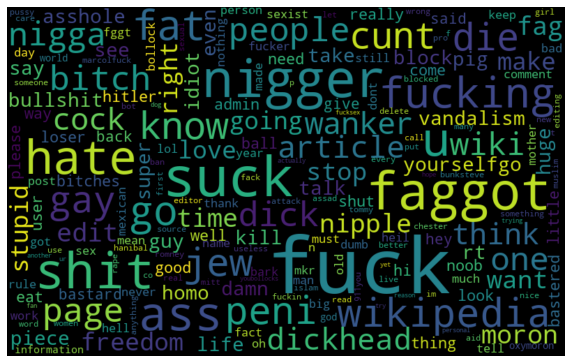

In [631]:
# generating a word cloud to see most frequent words in cyberbullying content
words = ' '.join([content for content in cb['content']])
wordcloud = WordCloud(width=800, height=500, random_state=18, max_font_size=110, collocations=False).generate(words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

It is clear to see how offensive and harmful these cyberbullying posts can be. From an emotional standpoint, seeing this WordCloud of frequent words in cyberbullying content is both disheartening and eye-opening. If preventative measures are not used, these are the words that bombard children when they are exposed to cyberbullying content on various social media platforms.  

It is important to note that these words are clearly offensive without any context at all, and that how they appear in a sentence may not matter very much in this case. Because of this, I have opted to go with a "Bag of Words" method for modeling. What this means is that the connection of words to one another in a sentence will not be taken account for the purposes of this model. Instead, I would like to train the model to focus on "trigger words" that can be immediately flagged as possible cyberbullying content.  

To that end, my data will be count vectorized and TF-IDF vectorized. Count Vectorizing counts the number of times that a single word appears in the entire corpus.

In [646]:
# creating instance of Count Vectorizer
count_vect = CountVectorizer(min_df=1, max_df=.5)
count_vect

CountVectorizer(max_df=0.5)

In [647]:
# fitting count vectorizer to processed content
count_vect.fit(processed.content)

# showing 20 words and their counts
list(islice(count_vect.vocabulary_.items(), 20))

[('get', 93838),
 ('fucking', 90165),
 ('real', 183148),
 ('dude', 72293),
 ('dirty', 67982),
 ('come', 53323),
 ('crook', 59258),
 ('rengel', 186126),
 ('dems', 64749),
 ('corrupt', 57376),
 ('joke', 119658),
 ('make', 137071),
 ('republicans', 186700),
 ('look', 133924),
 ('like', 131798),
 ('fuck', 90110),
 ('could', 57686),
 ('day', 62544),
 ('let', 130800),
 ('hour', 106829)]

The TF-IDF (Total Frequency - Inverse Document Frequency) weight tells us the number of times that a word appears in a document over the number of words in the document, times the total number of documents over the number of documents with the word in it. Rare words contain more information about the content of a document than words that are used many times throughout all the documents. Based on this, the  weights shown below are a statistical measure to evaluate how important a word is to a document.

In [673]:
# creating instance of TF-IDF Vectorizer
tfidf = TfidfVectorizer(min_df=.07)
tfidf_weights = tfidf.fit_transform(processed.content)
weights = np.asarray(tfidf_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': tfidf.get_feature_names(), 'weight': weights})
weights_df = weights_df.sort_values(by='weight', ascending=True)

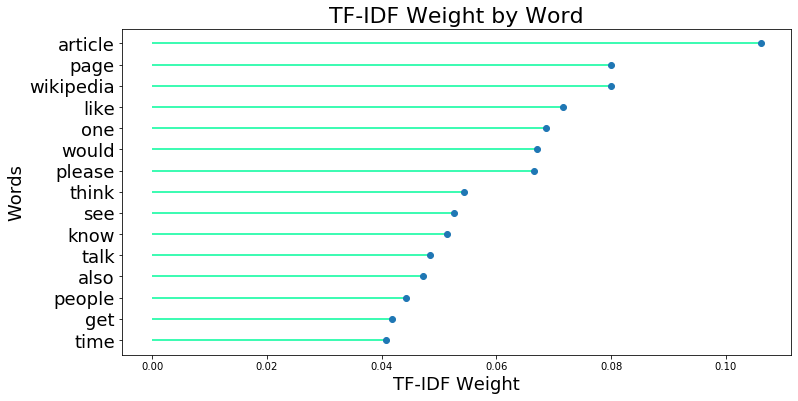

In [674]:
# plotting TF-IDF word weights
plt.figure(figsize=(12, 6))
my_range=range(1,len(weights_df.index)+1)
plt.hlines(y=my_range, xmin=0, xmax=weights_df['weight'], color='mediumspringgreen')
plt.plot(weights_df['weight'], my_range, "o")
plt.yticks(my_range, weights_df['word'], fontsize=18)
plt.title("TF-IDF Weight by Word", fontsize=22)
plt.xlabel('TF-IDF Weight', fontsize=18)
plt.ylabel('Words', fontsize=18);
#plt.xlim(0, 1);
#saved in images as fig11
#plt.tight_layout()
#plt.savefig('./images/fig11.png')